In [0]:
### INITIAL FLAIR TRAINING - MORTGAGE RATES
### Authors: JONATHAN CHAN 

###MOST RECENT UPDATE:  
##2020 MAY 20, 9:19PM
#got code working Google Colab
#initial 2 phase training experiment completed

#TO DO:
#convert labels of kaggle dataset to 1, -1, 0 instead of 'positive', 'negative', 'neutral'

In [2]:
!pip install flair

     |████████████████████████████████| 143kB 35.0MB/s 
     |████████████████████████████████| 983kB 46.7MB/s 
     |████████████████████████████████| 256kB 50.5MB/s 
     |████████████████████████████████| 798kB 54.2MB/s 
     |████████████████████████████████| 645kB 57.1MB/s 
     |████████████████████████████████| 1.1MB 57.8MB/s 
     |████████████████████████████████| 3.8MB 61.3MB/s 
     |████████████████████████████████| 890kB 57.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=2efaba13229ca82e1fc8b6657a109c0e4b42879be92a521ccb0b920a8e50643d
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
  Created wheel for segtok: filename=segtok-1.5.10-cp36-none-any.whl size=25020 sha256=7748e8125e837e6bc888b999e6c737bd08b57ca5b827d515b7bcd8a30a532c13
  Stored in directory: /root/.cache/pip/wheels/b4/39/f6/9ca1c5cabde964d728023b5751c3a206a5c8cc40252321fb6b
  Created wheel for mpld3:

In [0]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
from flair.data import Corpus
from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings, PooledFlairEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.data import Sentence
from flair.visual.training_curves import Plotter

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#use this install and restart runtime for this error: 
#ValueError: invalid literal for int() with base 10: '0+cpu' 

!pip install --upgrade git+https://github.com/flairNLP/flair.git

  Cloning https://github.com/flairNLP/flair.git to /tmp/pip-req-build-0yvfba56
  Running command git clone -q https://github.com/flairNLP/flair.git /tmp/pip-req-build-0yvfba56
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for flair: filename=flair-0.4.5-cp36-none-any.whl size=148505 sha256=558f25ebd16d1b03c5ca4a5e297a6ab546d0a49de10d097012406ef40472ee37
  Stored in directory: /tmp/pip-ephem-wheel-cache-ktw1rgms/wheels/84/82/73/d2b3b59b7be74ea05f2c6d64132efe27df52daffb47d1dc7bb
Successfully built flair
  Found existing installation: flair 0.4.5
    Uninstalling flair-0.4.5:
      Successfully uninstalled flair-0.4.5


# Training Phase 1 - Kaggle dataset
#### train.csv = 1000 rows
#### dev.csv = 300 rows
#### test.csv = 164 rows

In [3]:
# this is the folder in which train, test and dev files reside
#FOR CPU: 
#data_folder = 'experimental_flair_data/kaggle_data/'
#FOR COLAB: 
data_folder = "./drive/My Drive/Colab Notebooks/capstone/data/kaggle_data_downsampled"

# column format indicating which columns hold the text and label(s)
#column 0 = label (positive, negative, neutral)
#column 1 = headline
column_name_map = {2: "text", 1: "label_topic"}

# 1. load corpus containing training, test and dev data and if CSV has a header, you can skip it
corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=False, #no header in kaggle data
                                         delimiter=',',    # comma separated rows
) 
    



2020-05-21 22:36:36,340 Reading data from drive/My Drive/Colab Notebooks/capstone/data/kaggle_data_downsampled
2020-05-21 22:36:36,343 Train: drive/My Drive/Colab Notebooks/capstone/data/kaggle_data_downsampled/train.csv
2020-05-21 22:36:36,345 Dev: drive/My Drive/Colab Notebooks/capstone/data/kaggle_data_downsampled/dev.csv
2020-05-21 22:36:36,349 Test: drive/My Drive/Colab Notebooks/capstone/data/kaggle_data_downsampled/test.csv


In [4]:


# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('en-twitter'),

                   # comment in flair embeddings for state-of-the-art results
                  FlairEmbeddings('news-forward'),
                  FlairEmbeddings('news-backward'),
                   ]

# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )


2020-05-21 22:36:40,677 Computing label dictionary. Progress:


100%|██████████| 1164/1164 [00:00<00:00, 1395.23it/s]

2020-05-21 22:36:41,627 [b'label', b'0', b'-1', b'1']



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [5]:

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('resources/taggers/ag_news',
              learning_rate=0.01,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=10)

2020-05-21 22:37:30,037 ----------------------------------------------------------------------------------------------------
2020-05-21 22:37:30,039 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('en-twitter')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=4196, out_features=256, bias=True)
    (rnn): GRU(256, 51

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


2020-05-21 22:37:31,918 epoch 1 - iter 3/32 - loss 1.34688612 - samples/sec: 74.56
2020-05-21 22:37:33,449 epoch 1 - iter 6/32 - loss 1.31496938 - samples/sec: 63.95
2020-05-21 22:37:34,540 epoch 1 - iter 9/32 - loss 1.29985935 - samples/sec: 90.65
2020-05-21 22:37:35,756 epoch 1 - iter 12/32 - loss 1.28744711 - samples/sec: 80.22
2020-05-21 22:37:36,874 epoch 1 - iter 15/32 - loss 1.27093388 - samples/sec: 89.81
2020-05-21 22:37:38,114 epoch 1 - iter 18/32 - loss 1.25381856 - samples/sec: 79.36
2020-05-21 22:37:39,279 epoch 1 - iter 21/32 - loss 1.24237306 - samples/sec: 83.61
2020-05-21 22:37:40,494 epoch 1 - iter 24/32 - loss 1.23564775 - samples/sec: 82.32
2020-05-21 22:37:41,598 epoch 1 - iter 27/32 - loss 1.22839107 - samples/sec: 88.22
2020-05-21 22:37:42,768 epoch 1 - iter 30/32 - loss 1.22493540 - samples/sec: 83.62
2020-05-21 22:37:43,568 ----------------------------------------------------------------------------------------------------
2020-05-21 22:37:43,569 EPOCH 1 done: 

{'dev_loss_history': [1.4254571199417114,
  1.4655389785766602,
  1.3306286334991455,
  1.3973004817962646,
  1.425378680229187,
  1.4292048215866089,
  1.4459270238876343,
  1.4024531841278076,
  1.26520574092865,
  1.3610143661499023],
 'dev_score_history': [0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5016666666666667,
  0.5,
  0.5166666666666667,
  0.5033333333333333],
 'test_score': 0.5182926829268293,
 'train_loss_history': [1.222867265343666,
  1.1127750761806965,
  1.0908141881227493,
  1.0659586917608976,
  1.053624739870429,
  1.0383091922849417,
  1.024657927453518,
  1.0086243636906147,
  1.0066987425088882,
  1.0020265635102987]}

Weights plots are saved in resources/taggers/ag_news/weights.png
2020-05-21 22:41:57,896 loading file resources/taggers/ag_news/final-model.pt


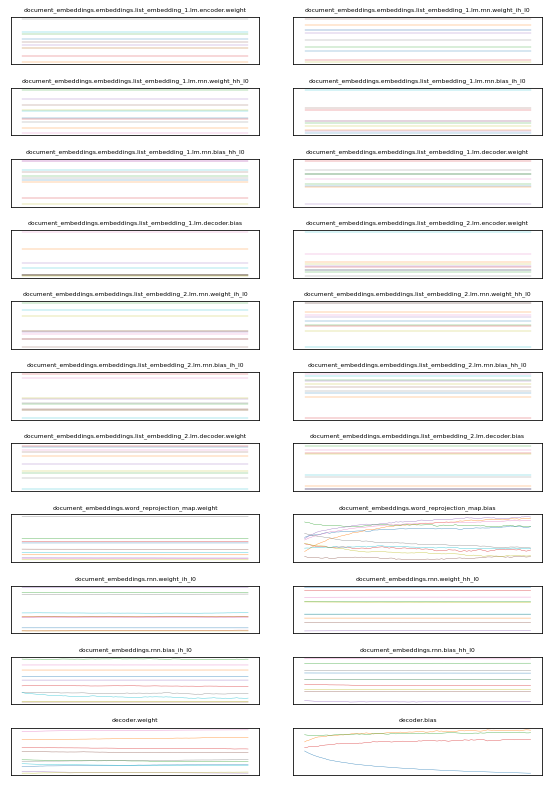

In [6]:
plotter = Plotter()
plotter.plot_weights('resources/taggers/ag_news/weights.txt')

classifier = TextClassifier.load('resources/taggers/ag_news/final-model.pt')


In [7]:
# create example sentence
sentence = Sentence("Canada's growth weakens as investment drops, consumers fade")

# predict class and print
classifier.predict(sentence)

print(sentence.labels)

[-1 (0.3753)]


# TRAINING PHASE II - GDP subset
#### train.csv = 132 rows
#### dev.csv and test.csv = 33 rows

In [8]:
# this is the folder in which train, test and dev files reside
#FOR CPU: 
#data_folder = 'experimental_flair_data/annotated_subset/'
#FOR COLAB: 
data_folder = "./drive/My Drive/Colab Notebooks/capstone/data/annotated_data_GDP"

# column format indicating which columns hold the text and label(s)
#column 2 = headline and description concatenation
#column 4 = label (-1, 0, 1)

column_name_map = {5: "text", 4: "label_topic"}

# load corpus containing training, test and dev data and if CSV has a header, you can skip it
# 1. get the corpus
corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter=',',    # tab-separated files
) 
    




2020-05-21 22:42:08,328 Reading data from drive/My Drive/Colab Notebooks/capstone/data/annotated_data_GDP
2020-05-21 22:42:08,329 Train: drive/My Drive/Colab Notebooks/capstone/data/annotated_data_GDP/train.csv
2020-05-21 22:42:08,330 Dev: drive/My Drive/Colab Notebooks/capstone/data/annotated_data_GDP/dev.csv
2020-05-21 22:42:08,334 Test: drive/My Drive/Colab Notebooks/capstone/data/annotated_data_GDP/test.csv


In [10]:

#REPEAT TRAINING PROCESS, but use same document_embeddings as in phase 1

# 2. create the label dictionary
# label_dict = corpus.make_label_dictionary()

# # 3. make a list of word embeddings
# word_embeddings = [WordEmbeddings('glove'),

#                    # comment in flair embeddings for state-of-the-art results
#                    # FlairEmbeddings('news-forward'),
#                    # FlairEmbeddings('news-backward'),
#                    ]

# # 4. initialize document embedding by passing list of word embeddings
# # Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
# document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
#                                                                      hidden_size=512,
#                                                                      reproject_words=True,
#                                                                      )

# # 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('resources/taggers/ag_news',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=10)

2020-05-21 22:54:26,892 ----------------------------------------------------------------------------------------------------
2020-05-21 22:54:26,894 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('en-twitter')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=4196, out_features=256, bias=True)
    (rnn): GRU(256, 51

{'dev_loss_history': [0.751253604888916,
  0.911827564239502,
  0.6771423816680908,
  0.6280238628387451,
  0.4539509415626526,
  0.4644159972667694,
  1.4450476169586182,
  0.44337794184684753,
  0.6389223337173462,
  0.427329957485199],
 'dev_score_history': [0.8363636363636363,
  0.7363636363636363,
  0.8151515151515152,
  0.8484848484848485,
  0.9121212121212121,
  0.8939393939393939,
  0.6909090909090909,
  0.8878787878787879,
  0.8303030303030303,
  0.896969696969697],
 'test_score': 0.803030303030303,
 'train_loss_history': [1.0562628269195558,
  0.673257339000702,
  0.6381301283836365,
  0.5832667946815491,
  0.5125627100467682,
  0.407866096496582,
  0.5061554133892059,
  0.6175013720989228,
  0.5123325049877167,
  0.4764415562152863]}

Weights plots are saved in resources/taggers/ag_news/weights.png
2020-05-21 23:04:16,930 loading file resources/taggers/ag_news/final-model.pt
[-1 (0.5176)]


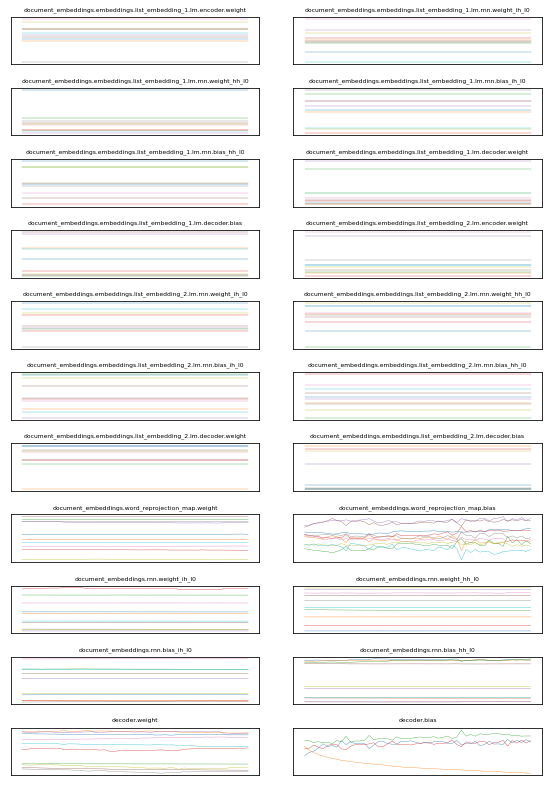

In [11]:
# 8. plot weight traces (optional)
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_weights('resources/taggers/ag_news/weights.txt')

classifier = TextClassifier.load('resources/taggers/ag_news/final-model.pt')

# create example sentence
sentence = Sentence("Canada's growth weakens as investment drops, consumers fade")

# predict class and print
classifier.predict(sentence)

print(sentence.labels)

In [12]:
classifier = TextClassifier.load('resources/taggers/ag_news/final-model.pt')

# create example sentence
sentence = Sentence("Canada's growth weakens as investment drops, consumers fade")

# predict class and print
classifier.predict(sentence)

print(sentence.labels)

2020-05-21 23:04:45,557 loading file resources/taggers/ag_news/final-model.pt
[-1 (0.5176)]
